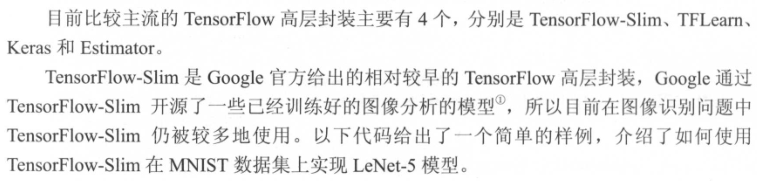

# TensorFlow-Slim

In [ ]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

# 通过Tensorflow-slim来定义LeNet-5的网络结构
def lenet5(inputs):
    # 将输入数据转化为一个4维数组，其中第一维表示batch大小，另三维表示一张图片
    inputs = tf.reshape(inputs, [-1, 28, 28, 1])
    
    # 定义第一层卷积层。该卷积层的深度为32，过滤器大小为5×5，使用全0填充
    net = slim.conv2d(inputs, 32, [5, 5], padding='SAME', scope='layer1-conv')
    # 定义一个最大池化层，其过滤器大小为2×2，步长为2
    net = slim.max_pool2d(net, 2, stride=2, scope='layer2-max-pool')
    
    # 类似定义其他的网络层结构
    net = slim.conv2d(net, 64, [5, 5], padding='SAME', scope='layer3-conv')
    net = slim.max_pool2d(net, 2, stride=2, scope='layer4-max-pool')
    
    # 下述函数将4维矩阵转化为2维，方便后面的全连接层的计算
    # 通过该函数，用户不需要自己计算通过该卷积层之后矩阵的大小
    net = slim.flatten(net, scope='flatten')
    
    # 定义全连接层，该层有500个隐藏节点
    net = slim.fully_connected(net, 500, scope='layer5')
    net = slim.fully_connected(net, 10, scope='output')
    
    return net

# 训练
def train(mnist):
    tf.reset_default_graph()
    # 定义输入
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y-input')
    
    y = lenet5(x)
    
    # 定义损失函数和训练方法
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=y,
        labels=tf.argmax(y_, 1))
    loss = tf.reduce_mean(cross_entropy)
    
    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    # 训练过程
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(10000):
            xs, ys = mnist.train.next_batch(100)
            _, loss_value = sess.run([train_op, loss], feed_dict={x: xs, y_: ys})
            
            if i % 1000 == 0:
                print('After %d training step(s), loss on training batch is %g.' %
                     (i, loss_value))
                
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=True)
    train(mnist)
    
if __name__ == '__main__':
    main()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
After 0 training step(s), loss on training batch is 2.30337.
After 1000 training step(s), loss on training batch is 0.824201.
After 2000 training step(s), loss on training batch is 0.398119.
After 3000 training step(s), loss on training batch is 0.436624.


# Estimator

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 将Tensorflow日志信息输出到屏幕
tf.logging.set_verbosity(tf.logging.INFO)
mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=False)

# 指定神经网络的输入层。所有这里指定的输入都会拼接在一起作为整个神经网络的输入
feature_columns = [tf.feature_column.numeric_column('image', shape=[784])]

# 通过Tensorflow提供的封装好的Estimator定义神经网络模型
# feature_columns参数表示神经网络输入层需要用到的数据
# hidden_units参数表示神经网络的结构，注意DNNClassifier只能定义多层全连接层神经网络，
#     而该参数列表中给出了每一层隐藏层的节点个数
# n_classes参数表示总类目数量
# optimizer参数表示优化函数
# model_dir参数表示训练过程中的loss变化以及其他指标保存的目录，通过TensorBoard来可视化
estimator = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [500],
    n_classes = 10,
    optimizer = tf.train.AdamOptimizer(),
    model_dir = '/opt/jupyter_files/model-saves/estimator')

# 定义数据输入
# x表示所有的输入数据，因为上面feature_columns只定义了一组输入，所以这里只需指定一个
# y表示x的正确答案
# num_epochs表示数据循环使用的轮数
# batch_size表示一个batch的大小
# shuffle表示是否需要对数据随机打乱
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': mnist.train.images},
    y = mnist.train.labels.astype(np.int32),
    num_epochs = None,
    batch_size = 128,
    shuffle = True)

# 训练模型
# 这里没有指定损失函数，通过DNNClassifier定义的模型会使用交叉熵作为损失函数
estimator.train(input_fn=train_input_fn, steps=10000)

# 定义测试时的数据输入。指定的形式和训练时的数据输入基本一致
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': mnist.test.images},
    y = mnist.test.labels.astype(np.int32),
    num_epochs = 1,
    batch_size = 128,
    shuffle = False)

# 通过evaluate评测训练好的模型的效果
accuracy_score = estimator.evaluate(input_fn=test_input_fn)['accuracy']
print('\nTest accuracy: %g %%' % (accuracy_score * 100))

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_service': None, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_master': '', '_task_type': 'worker', '_num_ps_replicas': 0, '_model_dir': '/opt/jupyter_files/model-saves/estimator', '_session_config': None, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc5662b7a20>}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /opt/jupyter_files/model-saves/estimator/model.ckpt-10000
INF

INFO:tensorflow:global_step/sec: 69.1425
INFO:tensorflow:step = 17201, loss = 0.0217243 (1.447 sec)
INFO:tensorflow:global_step/sec: 69.037
INFO:tensorflow:step = 17301, loss = 0.0152711 (1.448 sec)
INFO:tensorflow:global_step/sec: 72.1385
INFO:tensorflow:step = 17401, loss = 0.00144969 (1.386 sec)
INFO:tensorflow:global_step/sec: 67.1482
INFO:tensorflow:step = 17501, loss = 0.00936117 (1.492 sec)
INFO:tensorflow:global_step/sec: 69.3694
INFO:tensorflow:step = 17601, loss = 0.0152304 (1.439 sec)
INFO:tensorflow:global_step/sec: 69.0733
INFO:tensorflow:step = 17701, loss = 0.00586642 (1.447 sec)
INFO:tensorflow:global_step/sec: 70.5074
INFO:tensorflow:step = 17801, loss = 0.00280697 (1.419 sec)
INFO:tensorflow:global_step/sec: 70.9031
INFO:tensorflow:step = 17901, loss = 0.0111966 (1.410 sec)
INFO:tensorflow:global_step/sec: 70.7329
INFO:tensorflow:step = 18001, loss = 0.0027617 (1.413 sec)
INFO:tensorflow:global_step/sec: 70.4687
INFO:tensorflow:step = 18101, loss = 0.0101502 (1.420 se

## Estimator自定义模型

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.INFO)

# 通过tf.layers来定义模型结构
# x表示输入层张量
# is_training表示是否为训练
# 该函数返回前向传播的结果
def lenet(x, is_training):
    # 将输入转化为卷积层需要的形状
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    net = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, 2, 2)
    
    net = tf.layers.conv2d(net, 64, 3, activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, 2, 2)
    
    net = tf.contrib.layers.flatten(net)
    net = tf.layers.dense(net, 1024)
    net = tf.layers.dropout(net, rate=0.4, training=is_training)
    
    return tf.layers.dense(net, 10)

# 自定义Estimator中使用的模型
# features表示输入层张量
#     这是一个字典，内容通过tf.estimator.inputs.numpy_input_fn中y参数给定
# labels表示正确答案，通过numpy_input_fn中y参数给出
# mode取值3种可能，分别表示Estimator类的train,evaluate和predict这3个函数
# params是一个字典，表示模型相关的超参数，比如学习率等
def model_fn(features, labels, mode, params):
    # 定义神经网络的结构
    predict = lenet(features['image'], mode==tf.estimator.ModeKeys.TRAIN)
    # 如果在预测模式，只需要将结果返回即可
    if mode == tf.estimator.ModeKeys.PREDICT:
        # 使用EstimatorSpec传递返回值，并通过predictios参数指定返回的结果
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = {'result': tf.argmax(predict, 1)})
    
    # 定义损失函数
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predict, labels=labels))
    # 定义优化函数
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
    
    # 定义训练过程
    train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
    
    # 定义评测标准，在运行evaluate时会计算这里定义的所有评测标准
    eval_metric_ops = {'my_metric': tf.metrics.accuracy(tf.argmax(predict, 1), labels)}
    
    # 返回模型训练过程需要使用的损失函数、训练过程和评测方法
    return tf.estimator.EstimatorSpec(
        mode = mode,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops)

mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=False)

# 通过自定义的方式生成Estimator类
model_params = {'learning_rate': 0.01}
estimator = tf.estimator.Estimator(model_fn=model_fn, params=model_params)

# 训练和评测模型
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': mnist.train.images},
    y = mnist.train.labels.astype(np.int32),
    num_epochs = None,
    batch_size = 128,
    shuffle = True)
estimator.train(input_fn=train_input_fn, steps=30000)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': mnist.test.images},
    y = mnist.test.labels.astype(np.int32),
    num_epochs = 1,
    batch_size = 128,
    shuffle = False)
test_results = estimator.evaluate(input_fn=test_input_fn)

# 这里使用的my_metric中的内容是model_fn中eval_metric_ops定义的评测指标
accuracy_score = test_results['my_metric']
print('\nTest accuracy: %g %%' % (accuracy_score * 100))

# 使用训练好的模型在新数据上预测结果
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': mnist.test.images[:10]},
    num_epochs = 1,
    shuffle = False)
predictions = estimator.predict(input_fn=predict_input_fn)

for i, p in enumerate(predictions):
    # 这里result就是tf.estimator.EstimatorSpec的参数predictions中指定的内容
    # 因为这个内容是一个字典，所以Estimator可以很容易支持多输出
    print('Prediction %s: %s' % (i + 1, p['result']))

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_service': None, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_master': '', '_task_type': 'worker', '_num_ps_replicas': 0, '_model_dir': '/tmp/tmpv0n3ax65', '_session_config': None, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc564e57c18>}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpv0n3ax65/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.31514
INFO:tensor

INFO:tensorflow:step = 7101, loss = 0.0575124 (23.652 sec)
INFO:tensorflow:global_step/sec: 4.21773
INFO:tensorflow:step = 7201, loss = 0.116131 (23.706 sec)
INFO:tensorflow:global_step/sec: 4.24928
INFO:tensorflow:step = 7301, loss = 0.0417933 (23.535 sec)
INFO:tensorflow:global_step/sec: 4.18788
INFO:tensorflow:step = 7401, loss = 0.060705 (23.877 sec)
INFO:tensorflow:global_step/sec: 4.23989
INFO:tensorflow:step = 7501, loss = 0.0439801 (23.587 sec)
INFO:tensorflow:global_step/sec: 4.24892
INFO:tensorflow:step = 7601, loss = 0.171525 (23.535 sec)
INFO:tensorflow:Saving checkpoints for 7604 into /tmp/tmpv0n3ax65/model.ckpt.
INFO:tensorflow:global_step/sec: 4.19709
INFO:tensorflow:step = 7701, loss = 0.0556573 (23.828 sec)
INFO:tensorflow:global_step/sec: 4.24854
INFO:tensorflow:step = 7801, loss = 0.0431071 (23.536 sec)
INFO:tensorflow:global_step/sec: 4.21558
INFO:tensorflow:step = 7901, loss = 0.0427637 (23.721 sec)
INFO:tensorflow:global_step/sec: 4.22906
INFO:tensorflow:step = 80

INFO:tensorflow:global_step/sec: 4.26193
INFO:tensorflow:step = 15101, loss = 0.0644302 (23.463 sec)
INFO:tensorflow:global_step/sec: 4.21103
INFO:tensorflow:step = 15201, loss = 0.0198057 (23.749 sec)
INFO:tensorflow:Saving checkpoints for 15202 into /tmp/tmpv0n3ax65/model.ckpt.
INFO:tensorflow:global_step/sec: 4.20262
INFO:tensorflow:step = 15301, loss = 0.0308478 (23.795 sec)
INFO:tensorflow:global_step/sec: 4.24568
INFO:tensorflow:step = 15401, loss = 0.0249598 (23.554 sec)
INFO:tensorflow:global_step/sec: 4.20626
INFO:tensorflow:step = 15501, loss = 0.0487098 (23.772 sec)
INFO:tensorflow:global_step/sec: 4.25439
INFO:tensorflow:step = 15601, loss = 0.0283095 (23.504 sec)
INFO:tensorflow:global_step/sec: 4.22564
INFO:tensorflow:step = 15701, loss = 0.0168348 (23.665 sec)
INFO:tensorflow:global_step/sec: 4.17236
INFO:tensorflow:step = 15801, loss = 0.0652087 (23.968 sec)
INFO:tensorflow:global_step/sec: 4.22965
INFO:tensorflow:step = 15901, loss = 0.019811 (23.642 sec)
INFO:tensorfl

INFO:tensorflow:step = 22901, loss = 0.0307845 (23.802 sec)
INFO:tensorflow:global_step/sec: 4.18701
INFO:tensorflow:step = 23001, loss = 0.0101779 (23.883 sec)
INFO:tensorflow:global_step/sec: 4.16643
INFO:tensorflow:step = 23101, loss = 0.0186027 (24.000 sec)
INFO:tensorflow:global_step/sec: 4.18757
INFO:tensorflow:step = 23201, loss = 0.0180451 (23.882 sec)
INFO:tensorflow:global_step/sec: 4.19993
INFO:tensorflow:step = 23301, loss = 0.0684028 (23.809 sec)
INFO:tensorflow:global_step/sec: 4.23202
INFO:tensorflow:step = 23401, loss = 0.0104366 (23.630 sec)
INFO:tensorflow:global_step/sec: 4.23587
INFO:tensorflow:step = 23501, loss = 0.0241317 (23.607 sec)
INFO:tensorflow:global_step/sec: 4.1941
INFO:tensorflow:step = 23601, loss = 0.0662324 (23.843 sec)
INFO:tensorflow:global_step/sec: 4.22878
INFO:tensorflow:step = 23701, loss = 0.0309735 (23.647 sec)
INFO:tensorflow:global_step/sec: 4.2194
INFO:tensorflow:step = 23801, loss = 0.00556304 (23.703 sec)
INFO:tensorflow:global_step/sec:

## 使用数据集作为Estimator输入

In [51]:
import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.INFO)

# Estimator的自定义输入函数需要每一次被调用时可以得到一个batch的数据
# 通过数据集可以很自然地实现这个过程
# 虽然Estimator要求的自定义输入函数不能有参数
# 但是通过python提供的lambda表达式可以快速将下面的函数转化为不带参数的函数
def my_input_fn(file_path, perform_shuffle=False, repeat_count=1):
    # 定义解析csv文件中一行的方法
    def decode_csv_files(line):
        # 将一行中的数据解析出来。注意iris最后一列为标签，其他列为特征
        record_defaults = [[0.], [0.], [0.], [0.], [0]]
        parsed_line = tf.decode_csv(line, record_defaults)
        # Estimator的输入函数要求特征是一个字典，所以这里返回的也需要是字典
        # 字典中key的定义需要和DNNClassifier中feature_columns的定义匹配
        return {'x': parsed_line[:-1]}, parsed_line[-1:]
    
    # 使用数据集处理输入数据
    dataset = (tf.contrib.data.TextLineDataset(file_path)
               .skip(1)
               .map(decode_csv_files))
    if perform_shuffle:
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)
    dataset = dataset.batch(32)
    
    iterator = dataset.make_one_shot_iterator()
    # 通过定义的数据集得到一个batch的输入数据
    # 这个就是整个自定义输入过程的返回结果
    batch_features, batch_labels = iterator.get_next()
    # 如果是为预测过程提供输入数据，那么baatch_labels可以直接使用None
    
    return batch_features, batch_labels

tf.reset_default_graph()

# 定义Estimator
feature_columns = [tf.feature_column.numeric_column('x', shape=[4])]
classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [10, 10],
    n_classes = 3)

# 用lambda表达式将训练相关信息
# 传入自定义输入数据处理函数并生成Estimator需要的输入函数
classifier.train(
    input_fn=lambda: my_input_fn('/opt/jupyter_files/iris/iris_training.csv',
                                 True,
                                 10))

# 使用lambda表达式将测试相关的信息
# 传入自定义输入数据处理函数并生成Estimator需要的输入函数
# 通过lambda表达式的方式可以大大减少冗余代码
test_results = classifier.evaluate(
    input_fn=lambda: my_input_fn('/opt/jupyter_files/iris/iris_test.csv',
                                False,
                                1))
print('\nTest accuracy: %g %%' % (test_results['accuracy'] * 100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_service': None, '_save_checkpoints_steps': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdef43042b0>, '_model_dir': '/tmp/tmp59594qv3', '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_task_type': 'worker'}


AttributeError: 'list' object has no attribute 'get_shape'